# Projet 4 : Anticipez les besoins en consommation électrique de bâtiments

In [ ]:
# Restore the kernel
import dill
dill.load_session('kernels/p4_explor_kernel.db')

# Analyse exploratoire

## Import des modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Récupération des données

In [2]:
data_2015 = pd.read_csv("data/2015-building-energy-benchmarking.csv")
data_2016 = pd.read_csv("data/2016-building-energy-benchmarking.csv")

## **Exploration initiale des données**

In [3]:
def shape(dataframe):
    """Calcuates and displays the shape of the dataframe and the filling rage"""
    
    # get the numbers of rows and columns in the dataframe
    nb_rows, nb_columns = dataframe.shape
    print("\nDataFrame has {} rows and {} columns.".format(nb_rows,nb_columns))

    # get the number of non-Nan data in the dataframe
    nb_data = dataframe.describe(include='all').loc["count"].sum()

    # computing the filling rate by rounding down to 2 decimal places
    import math
    filling_rate = math.floor(nb_data*10000 / (nb_rows * nb_columns))/10000
    print("The global filling rate of the DataFrame is : {:.2%}".format(filling_rate))
    
    # computing the missing values
    nb_missing = int((nb_rows * nb_columns) - nb_data)
    print("There are {} missing values out of {}.".format(nb_missing, int(nb_rows * nb_columns)))

In [4]:
shape(data_2015)
shape(data_2016)


DataFrame has 3340 rows and 47 columns.
The global filling rate of the DataFrame is : 83.11%
There are 26512 missing values out of 156980.

DataFrame has 3376 rows and 46 columns.
The global filling rate of the DataFrame is : 87.15%
There are 19952 missing values out of 155296.


In [5]:
data_2015.head(1)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,...,GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'human_address': '{""address"": ""405 OLIVE WAY""...",7,DOWNTOWN,1927,...,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081


In [6]:
data_2016.head(1)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1156514.25,3946027.0,12764.5293,1276453.0,False,NaN,Compliant,NaN,249.98,2.83


Nous constatons que la plupart des lignes (correspondant à un batîment particulier) se retrouvent à la fois dans les données de 2015 et dans celles de 2016.

L'agrégation des données de 2015 et de 2016 nécessitera donc de gérer les données dupliquées.

In [7]:
print("\nNames of the {} common columns :\n".format(len(set(data_2015)&set(data_2016))), set(data_2015)&set(data_2016))
print("\nNames of the {} columns only in 2015 dataset:\n".format(len(set(data_2015)-set(data_2016))), set(data_2015)-set(data_2016))
print("\nNames of the {} columns only in 2016 dataset:\n".format(len(set(data_2016)-set(data_2015))), set(data_2016)-set(data_2015))


Names of the 37 common columns :
 {'CouncilDistrictCode', 'OSEBuildingID', 'Electricity(kBtu)', 'SecondLargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'TaxParcelIdentificationNumber', 'PropertyGFAParking', 'NaturalGas(therms)', 'PropertyGFATotal', 'SourceEUIWN(kBtu/sf)', 'PropertyName', 'ComplianceStatus', 'NumberofBuildings', 'YearsENERGYSTARCertified', 'SteamUse(kBtu)', 'SiteEUIWN(kBtu/sf)', 'ThirdLargestPropertyUseTypeGFA', 'SourceEUI(kBtu/sf)', 'DataYear', 'SiteEnergyUseWN(kBtu)', 'BuildingType', 'SecondLargestPropertyUseTypeGFA', 'SiteEnergyUse(kBtu)', 'PrimaryPropertyType', 'Outlier', 'NumberofFloors', 'ENERGYSTARScore', 'PropertyGFABuilding(s)', 'SiteEUI(kBtu/sf)', 'LargestPropertyUseType', 'YearBuilt', 'NaturalGas(kBtu)', 'ListOfAllPropertyUseTypes', 'ThirdLargestPropertyUseType', 'DefaultData', 'Neighborhood', 'Electricity(kWh)'}

Names of the 10 columns only in 2015 dataset:
 {'Comment', 'OtherFuelUse(kBtu)', 'Location', 'SPD Beats', 'City Council Districts', 'Seattle 

Nous constatons que certains colonnes spécifiques ont en fait la même sémantique. Par exemple :
* la colonne 'Comment' de 2015 correspond à la colonne 'Comments' de 2016
* la colonne 'Zip Codes' de 2015 correspond à la colonne 'ZipCode' de 2016
* la colonne 'GHGEmissionsIntensity(kgCO2e/ft2)' de 2015 correspond à la colonne 'GHGEmissionsIntensity' de 2016
* la colonne 'GHGEmissions(MetricTonsCO2e)' de 2015 correspond à la colonne 'TotalGHGEmissions' de 2016

In [8]:
# Renaming a column to adopt names of 2016 database
data_2015 = data_2015.rename(columns={
    'GHGEmissions(MetricTonsCO2e)':"TotalGHGEmissions",
    'Comment':'Comments',
    'Zip Codes':'ZipCode',
    'GHGEmissionsIntensity(kgCO2e/ft2)':'GHGEmissionsIntensity',
})

Nous constatons aussi que certains colonnes spécifiques ont été reformatées. Ainsi, la colonne 'Location' de 2015 a été séparée en plusieurs colonnes en 2016 :
* 'State'
* 'City'
* 'Address'
* 'Longitude'
* 'Latitude'

## Concaténation

In [9]:
data = pd.concat([data_2015, data_2016], sort=False)
shape(data)


DataFrame has 6716 rows and 52 columns.
The global filling rate of the DataFrame is : 76.11%
There are 83420 missing values out of 349232.


## Fusion des lignes correspondant à des bâtiments dupliqués
Nous identifions les bâtiments dupliqués sur la base de l'identifiant 'OSEBuildingID'.

Nous fusionnons ensuite les lignes et supprimons les doublons.

In [10]:
def duplicates_merging(dataframe, keys):
    """This function handles duplicates rows in the dataframe, based on a subset of columns (features)."""

    # Checking if there are some duplicated rows
    duplicates_mask = dataframe.duplicated(subset=keys, keep=False)
    if True not in list(duplicates_mask.unique()):
        print("No duplicates.")
        return dataframe
    
    print("Number of duplicates rows :", len(dataframe[duplicates_mask]))
    
    # Filtering the dataframe to keep only duplicated rows
    duplicates_mask = dataframe.duplicated(subset=keys, keep=False)
    duplicates_df = dataframe[duplicates_mask]

    # Group-by subset of columns used for key, sort=False to speed-up
    gb = duplicates_df.groupby(keys, sort=False)

    # Initializing aggregated dataframe
    agg_df = pd.DataFrame()

    # Identification of numerical and non-numerical columns
    numeric_columns = list(dataframe.select_dtypes(include=[np.number]).columns.values)

    # defining aggregation function for non-numerical columns
    def agg_mode(x): m = pd.Series.mode(x); return m.values[0] if not m.empty else np.nan

    # Iterating upon columns
    for column in dataframe.columns:

        # Calculate the mean of each group for numeric columns
        if column in numeric_columns:
            agg_col = gb[column].agg('mean')

        # Calculate the mode of each group for numeric columns
        else:
            agg_col = gb[column].agg(agg_mode)
            
        # adding the aggregated column to aggregated dataframe
        agg_df = pd.concat([agg_df, agg_col], axis=1, sort=True)

    # Dropping all duplicates
    dataframe_cleaned = dataframe.drop_duplicates(subset=keys, keep=False)

    # Concatenating the dataframe without duplicates and the aggregated rows for duplicates
    result = dataframe_cleaned.append(agg_df, ignore_index=True, sort=False)

    print("Shape after handling duplicates :", result.shape)
    return result

In [11]:
%%capture --no-stdout --no-display

dataframe = data
keys = ['OSEBuildingID']

data = duplicates_merging(dataframe, keys)
shape(data)

Number of duplicates rows : 6568
Shape after handling duplicates : (3432, 52)

DataFrame has 3432 rows and 52 columns.
The global filling rate of the DataFrame is : 84.76%
There are 27184 missing values out of 178464.


## Retypage des variables catégorielles

In [12]:
# Select columns of object dtypes
obj_columns = list(data.select_dtypes(include='object').columns)

# Convert object dtypes features as categorical data ('category' dtypes)
data[obj_columns] = data[obj_columns].astype('category')

## Suppression des données où la cible est manquante

Certaines données n'ont pas de valeurs renseignées pour les cibles.
Nous allons supprimer ces données inexploitables.

In [13]:
def missing_target(dataframe, target):
    """This function takes a dataframe and target feature, and returns
    a view of the dataframe containing the rows where the target value is missing.
    It also remove these rows from the original dataframe."""
    
    # Mask for rows where the target value is missing
    mask = dataframe[target].isnull()
    
    # Applying the mask to the dataframe and saving it as a copy
    result = dataframe[mask].copy()
    
    # Deleting the rows with missing target from the dataframe
    dataframe.dropna(subset=[target], inplace=True)
    
    # Returning a dataframe with rows where target is missing
    return result

In [14]:
target_cols = ['SiteEnergyUse(kBtu)','TotalGHGEmissions']
dataframe = data

# Initializing
production_set = pd.DataFrame()

# concatenating rows with missing values on any target
for target in target_cols:
    production_set = pd.concat([
        production_set,
        missing_target(dataframe, target)
    ])

# dropping duplicates rows (missing several targets)
production_set = production_set.drop_duplicates(keep='first').copy()

# Display the 'production set' on which to apply the ML model
production_set

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,...,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,ZipCode,Address,City,State,Latitude,Longitude
36,24408,2015.0,SPS-District K-12,K-12 School,WILSON-PACIFIC (SPS-DISTRICT),3126049064,"{'human_address': '{""address"": ""1330 N 90TH ST...",5.0,NORTHWEST,1953,...,NaN,46.0,NaN,34.0,18377.0,NaN,NaN,NaN,NaN,NaN
65,23437,2016.0,Multifamily LR (1-4),Low-Rise Multifamily,MERCER CREST APT,3876900230,NaN,7.0,MAGNOLIA / QUEEN ANNE,1957,...,NaN,NaN,NaN,NaN,98119.0,500 W MERCER ST,Seattle,WA,47.62479,-122.36364
900,19798,2015.5,Multifamily LR (1-4),Low-Rise Multifamily,SANDHURST APTS,0225049032,"{'human_address': '{""address"": ""7239 SAND POIN...",4.0,NORTHEAST,1977,...,NaN,55.0,NaN,48.0,58453.5,7239 SAND POINT WAY NE,Seattle,WA,47.68149,-122.26471
120,50082,2016.0,Multifamily LR (1-4),Low-Rise Multifamily,STREAM FIFTEEN,3303700030,NaN,3.0,EAST,2015,...,NaN,NaN,NaN,NaN,98112.0,605 15TH AVE E,Seattle,WA,47.62441,-122.31300


## Sauvegarde des données "brutes"

Nous sauvegardons ces données brutes pour faire un essai de modélisation.

In [15]:
# Save the file
data.to_csv("p4_data_raw.csv")

## **Nettoyage**

### Suppression des données non-explicatives
Nous supprimons les variables (colonnes) qui n'apportent aucun élément explicatif.

In [16]:
features_to_drop = [         
    'DataYear',
    'PropertyName',
    'TaxParcelIdentificationNumber',
    'Comments',
    'Seattle Police Department Micro Community Policing Plan Areas',
    'City Council Districts',
    'SPD Beats',
    'Location',
    'ZipCode',
    'State',
    'Address',
    'City'
]

# Drop several columns
for feature in features_to_drop:
    data = data.drop(feature, axis=1)

### Suppression des données issues des relevés de consommation annuels
Nous supprimons aussi les variables (colonnes) issues des relevés de consommation annuels (hormis ceux qui seront utilisés comme étiquette pour la régression) et celles que nous convertirons en variables booléennes.

In [17]:
features_to_drop2 = [         
        'SiteEUI(kBtu/sf)',
        'SiteEUIWN(kBtu/sf)',
        'SourceEUI(kBtu/sf)',
        'SourceEUIWN(kBtu/sf)',
        'SiteEnergyUseWN(kBtu)',
        'Electricity(kWh)',
        'NaturalGas(therms)',
        'Outlier',
        'GHGEmissionsIntensity'
]

# Drop several columns
for feature in features_to_drop2:
    data = data.drop(feature, axis=1)

Enfin, nous éliminons l'identifiant des bâtiments qui ne nous sera plus utile.

In [18]:
# Delete the identifier of buildings
data = data.drop('OSEBuildingID', axis=1)

Les colonnes correspondant aux types d'énergie consommées ne sont pas encore supprimées : elles seront converties en variables booléennes.

## Étude du taux de remplissage des variables

In [19]:
nb_rows, nb_columns = data.shape

# Count of the values on each column
columns_count = data.count()

# Sort the Series
columns_count = columns_count.sort_values(ascending=False)

# Calculating filling rates
filling_rates = columns_count / nb_rows

# Display the filling rates
filling_rates

BuildingType                       1.000000
SteamUse(kBtu)                     1.000000
PropertyGFAParking                 1.000000
PropertyGFATotal                   1.000000
NumberofFloors                     1.000000
NumberofBuildings                  1.000000
YearBuilt                          1.000000
Neighborhood                       1.000000
PropertyGFABuilding(s)             1.000000
SiteEnergyUse(kBtu)                1.000000
Electricity(kBtu)                  1.000000
NaturalGas(kBtu)                   1.000000
CouncilDistrictCode                1.000000
TotalGHGEmissions                  1.000000
DefaultData                        1.000000
ComplianceStatus                   1.000000
PrimaryPropertyType                1.000000
ListOfAllPropertyUseTypes          0.993874
LargestPropertyUseTypeGFA          0.992124
LargestPropertyUseType             0.992124
Longitude                          0.983956
Latitude                           0.983956
OtherFuelUse(kBtu)              

### Élimination des colonnes trop peu remplies
Nous décidons de ne conserver que les colonnes remplies à 75% minimum pour la modélisation.

Cela nous permet de conserver la variable ENERGYSTARScore dont nous devrons étudier la pertinence (dans la partie modélisation).

In [20]:
def fillingrate_filter_columns(dataframe, limit_rate):
    """This function drop the colums where the filling rate is less than a defined limit rate."""

    # Count of the values on each column
    columns_count = dataframe.count()

    # Number of rows in the dataframe
    nb_rows = dataframe.shape[0]
    
    # Calculating filling rates
    filling_rates = columns_count / nb_rows

    # Define a mask of features with a filling_rate bigger than the limit rate
    mask = filling_rates > limit_rate
    
    # Apply the mask to the filling_rates Series
    filling_rates_selection = filling_rates[mask]
    
    # Get the list of the name of the selected columns
    features_selection = list(filling_rates_selection.index)
    print("Number of columns with a filling rate bigger than  {:.2%} : {} columns.".format(limit_rate, len(features_selection)))

    # Return a projection on the selection of features
    return dataframe[features_selection]

In [21]:
data = fillingrate_filter_columns(data, 0.75)
shape(data)

Number of columns with a filling rate bigger than  75.00% : 24 columns.

DataFrame has 3428 rows and 24 columns.
The global filling rate of the DataFrame is : 98.71%
There are 1055 missing values out of 82272.


### Étude du remplissage des lignes

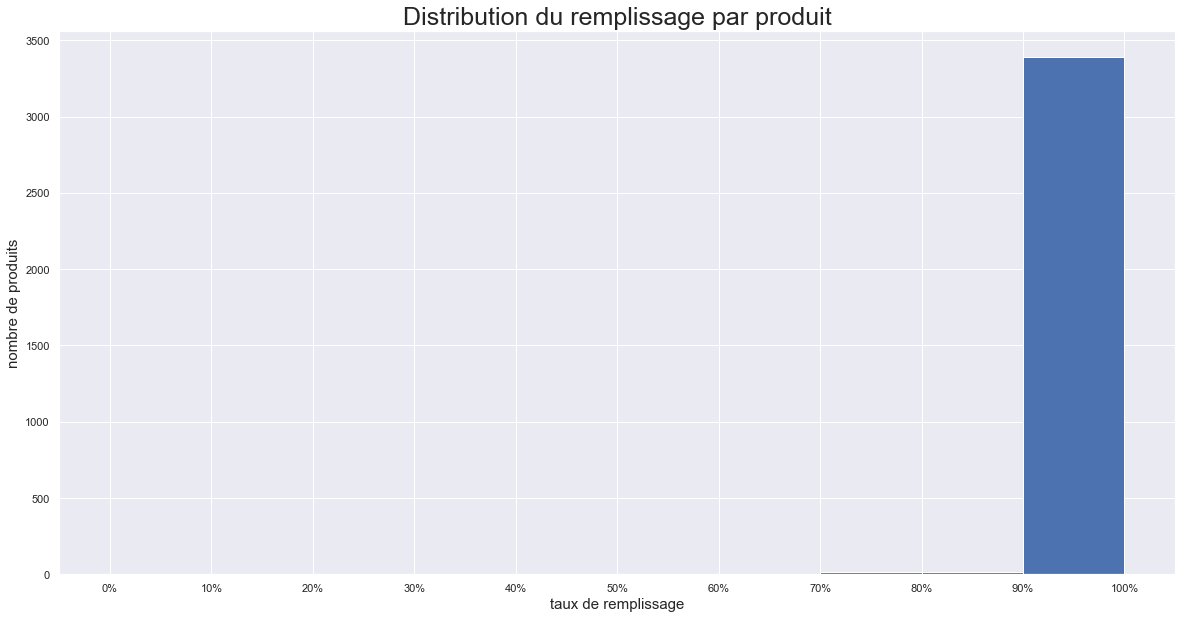

In [22]:
# Count the non-null values on each row
row_count = data.count(axis=1)

# Calculating filling rates
nb_columns = data.shape[1]
filling_rates_row = row_count / nb_columns

# Plotting histogram
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(20, 10))
plt.title("Distribution du remplissage par produit", fontsize=25)
plt.xlabel("taux de remplissage", fontsize=15)
plt.ylabel("nombre de produits", fontsize=15)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
bins = np.linspace(0, 1, num=11)
ax.hist(filling_rates_row, bins=bins)
ax.xaxis.set_major_locator(plt.MaxNLocator(11))
plt.show()

Nous constatons que la majeur partie des lignes est remplie à plus de 90%.
Nous allons faire de l'imputation pour les dernières valeurs manquantes.

# **Études univariées des variables cibles**
Nous allons étudier la distribution des variables 'SiteEnergyUse(kBtu)' et 'TotalGHGEmissions' et tester leur normalité.

## Indicateurs statistiques principaux

In [23]:
# .describe() pour min-max…
data[['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']].describe()

,SiteEnergyUse(kBtu),TotalGHGEmissions
count,3.428000e+03,3428.000000
mean,5.399557e+06,119.311982
std,2.153155e+07,534.287074
min,0.000000e+00,0.090000
25%,9.297253e+05,9.568750
50%,1.794819e+06,33.842500
75%,4.197331e+06,91.890000
max,8.739237e+08,16870.980000


## Distributions empiriques initiales

In [24]:
def empirical_distribution(dataframe, feature):
    """Function plotting the bar plot and a boxplot (as subplots) for a distribution."""
    
    # Loading libraries
    import matplotlib.pyplot as plt
    import seaborn as sns

    # filtering non-null data
    mask = dataframe[feature].notnull()
    data_view = dataframe[mask]
    
    # Setting the data to plot
    x = data_view[feature]
    
    # Create a figure instance, and the two subplots
    fig = plt.figure(figsize=(20, 10))
    plt.suptitle("Statistical distribution: " + feature, fontsize=25)
    ax1 = fig.add_subplot(211) # histogram
    ax2 = fig.add_subplot(212) # boxplot

    # Tell distplot to plot on ax1 with the ax argument
    sns.distplot(x, ax=ax1)
    ax1.set_ylabel("Frequency", fontsize=20)
    ax1.set_xlabel("")

    # Tell the boxplot to plot on ax2 with the ax argument
    medianprops = {'color':"black"}
    meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
    sns.boxplot(x,
                ax=ax2,
                showfliers=True,
                medianprops=medianprops,
                showmeans=True,
                meanprops=meanprops)
    ax2.set_xlabel("Value", fontsize=20)

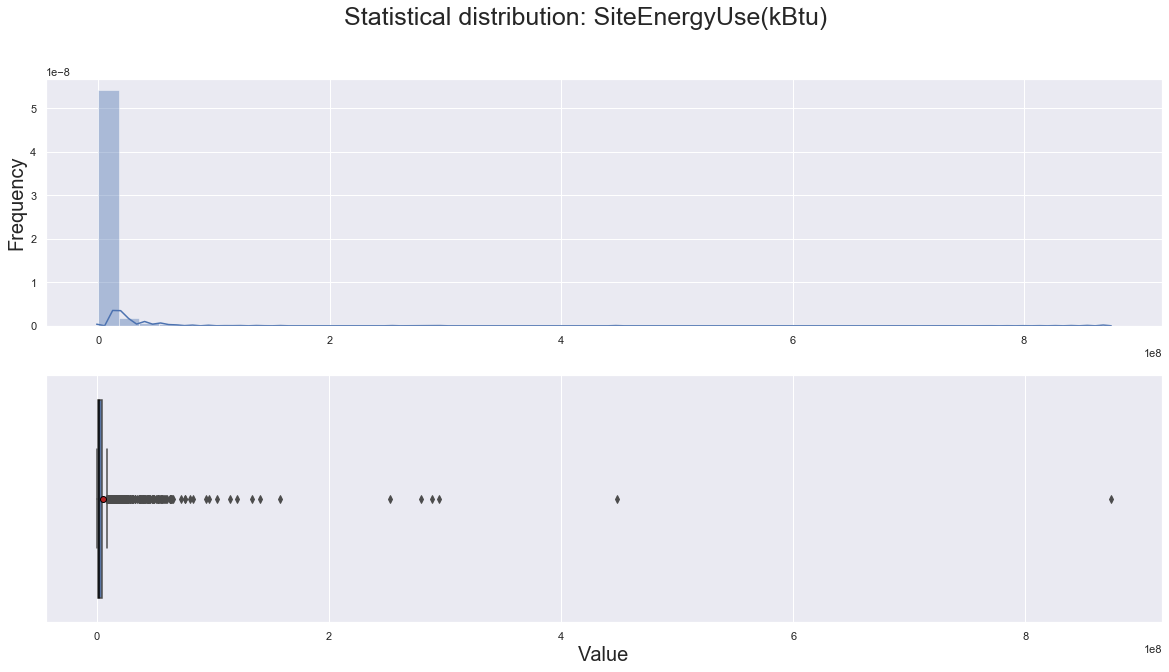

In [25]:
# Setting parameters before calling the function
dataframe = data
feature = 'SiteEnergyUse(kBtu)'

# Call to the function
empirical_distribution(dataframe, feature)

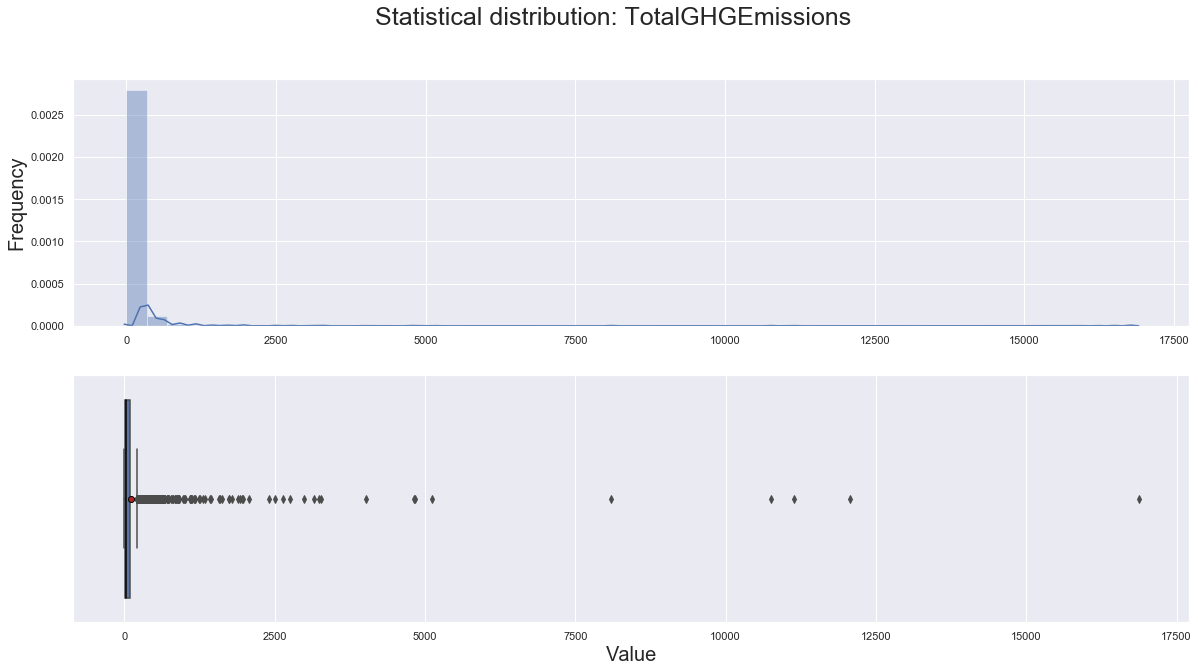

In [26]:
# Setting parameters before calling the function
dataframe = data
feature = 'TotalGHGEmissions'

# Call to the function
empirical_distribution(dataframe, feature)

## Transformation logarithmique

In [27]:
# Transformation logarithmique
data['SiteEnergyUse(kBtu)'] = np.log(data['SiteEnergyUse(kBtu)'] + 1) # +1 to avoid null values

data['TotalGHGEmissions'] = np.log(data['TotalGHGEmissions'] + 1) # +1 to avoid null values

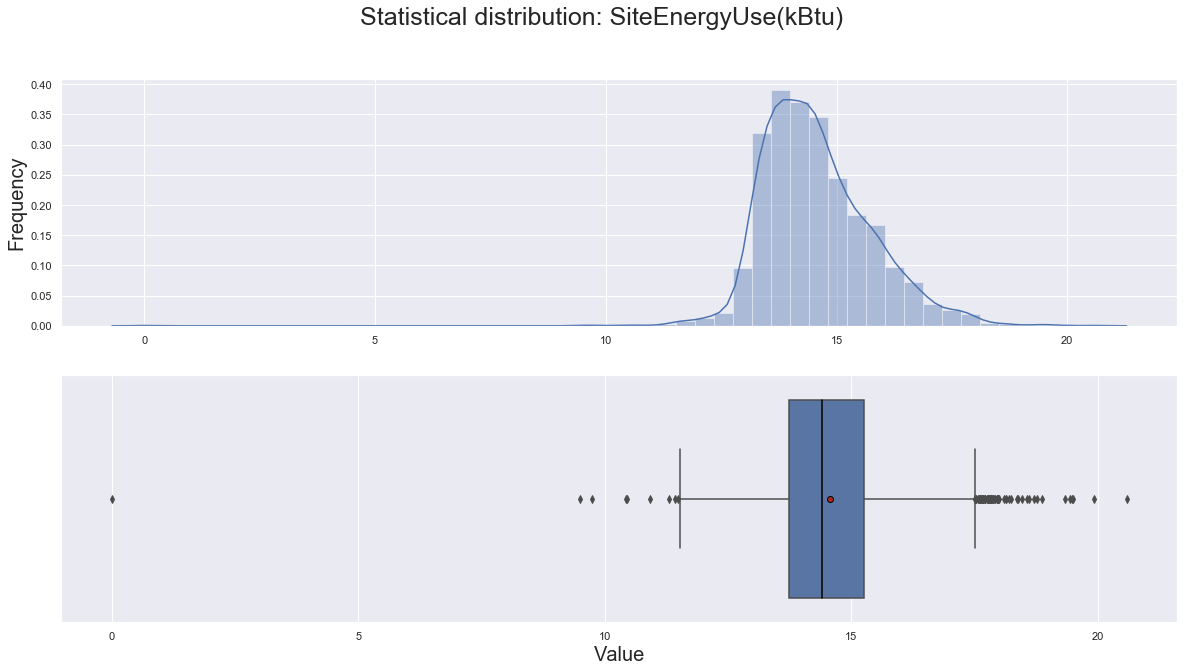

In [28]:
# Setting parameters before calling the function
dataframe = data
feature = 'SiteEnergyUse(kBtu)'

# Call to the function
empirical_distribution(dataframe, feature)

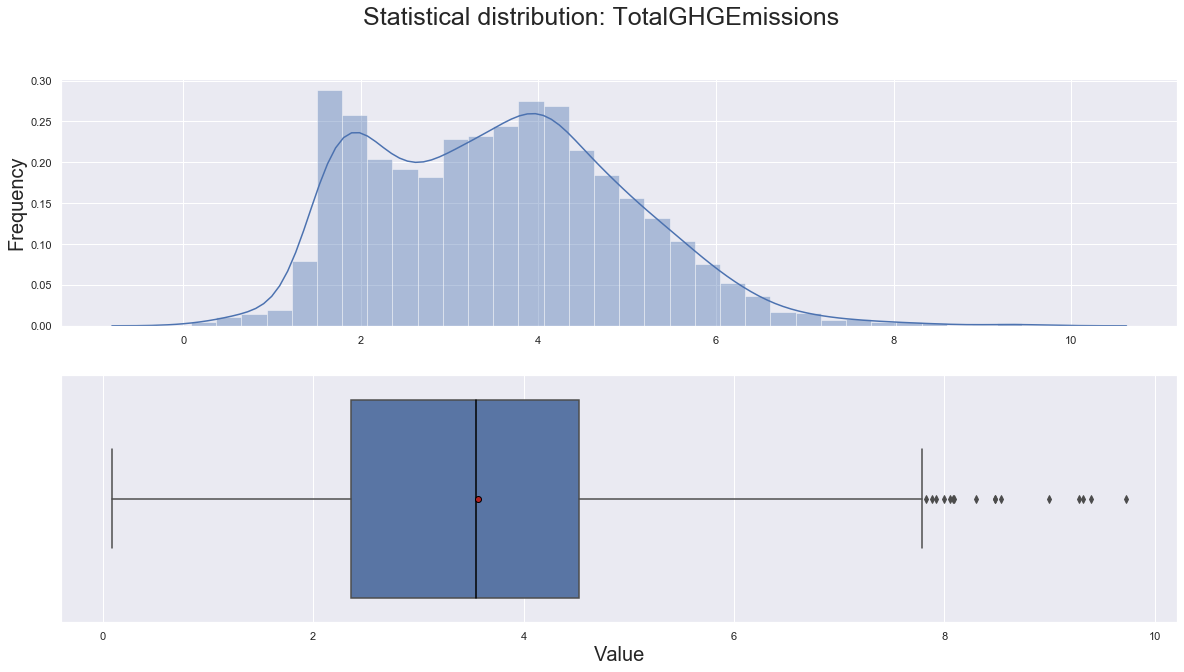

In [29]:
# Setting parameters before calling the function
dataframe = data
feature = 'TotalGHGEmissions'

# Call to the function
empirical_distribution(dataframe, feature)

## Tests de normalité (Shapiro-Wilk)

Il semble que les variables cibles ('TotalGHGEmissions', 'SiteEnergyUse(kBtu)') ne soient pas normalement distribuées. Nous allons le vérifier avec un test statistique :

    H0 : les valeurs de la variable aléatoire pour l'échantillon sont issus d'une population normalement distribuée.

    H1 :  les valeurs de la variable aléatoire pour l'échantillon NE sont PAS issus d'une population normalement distribuée

In [30]:
def shapiro_wilk(dataframe, feature):
    '''This function proceed to the Shapiro-Wilk test (for gaussian distribution).
    It takes a dataframe and the name of the feature to test.
    It filters for non-null vallues of the feature and print the results.'''
    
    # Loading libraries
    from scipy.stats import shapiro

    # filtering non-null data for the feature
    mask = dataframe[feature].notnull()
    data_view = dataframe[mask][feature]

    # processing the Shopiro-Wilk test on the filtered data
    results = shapiro(data_view)

    # Print results
    print("Shapiro-Wilk test's statistic value is: W = {}".format(results[0]))
    print("Shapiro-Wilk test's p-value is: p = {}".format(results[1]))
    print("\nGaussian distribution hypothesis for \'{}\' can be rejected at a risk of {:.2f}%.".format(feature, results[1]*100))

In [31]:
dataframe = data
feature = 'SiteEnergyUse(kBtu)'
shapiro_wilk(dataframe, feature)

Shapiro-Wilk test's statistic value is: W = 0.945440411567688
Shapiro-Wilk test's p-value is: p = 7.244384798883076e-34

Gaussian distribution hypothesis for 'SiteEnergyUse(kBtu)' can be rejected at a risk of 0.00%.


In [32]:
dataframe = data
feature = 'TotalGHGEmissions'
shapiro_wilk(dataframe, feature)

Shapiro-Wilk test's statistic value is: W = 0.9806946516036987
Shapiro-Wilk test's p-value is: p = 3.267865665234708e-21

Gaussian distribution hypothesis for 'TotalGHGEmissions' can be rejected at a risk of 0.00%.


# **Ingéniérie des caractéristiques** (*features engineering*)

In [33]:
data.head()

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),...,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),OtherFuelUse(kBtu),TotalGHGEmissions,DefaultData,ComplianceStatus,Latitude,Longitude
0,Multifamily LR (1-4),Low-Rise Multifamily,7.0,DOWNTOWN,1900,1.0,4.0,48383.0,0.0,48383.0,...,14.898447,915977.0,1448859.0,588563.0,0.0,4.727919,No,Compliant,NaN,NaN
1,Multifamily LR (1-4),Low-Rise Multifamily,1.0,DELRIDGE,2007,1.0,4.0,52134.0,0.0,52134.0,...,14.008238,0.0,1212601.0,0.0,0.0,2.246015,Yes,Compliant,NaN,NaN
2,NonResidential,Retail Store,7.0,DOWNTOWN,1989,1.0,4.0,111077.0,0.0,111077.0,...,16.107917,0.0,9899135.0,0.0,0.0,4.248638,No,Compliant,NaN,NaN
3,NonResidential,Small- and Mid-Sized Office,7.0,DOWNTOWN,1906,1.0,6.0,98370.0,25920.0,72450.0,...,15.691288,0.0,6488262.0,37893.0,0.0,3.876189,No,Compliant,NaN,NaN
4,NonResidential,Large Office,7.0,LAKE UNION,1947,1.0,4.0,193788.0,37854.0,155934.0,...,16.634519,0.0,16760914.0,0.0,0.0,4.769328,No,Compliant,NaN,NaN


In [34]:
data.dtypes

BuildingType                 category
PrimaryPropertyType          category
CouncilDistrictCode           float64
Neighborhood                 category
YearBuilt                       int64
NumberofBuildings             float64
NumberofFloors                float64
PropertyGFATotal              float64
PropertyGFAParking            float64
PropertyGFABuilding(s)        float64
ListOfAllPropertyUseTypes    category
LargestPropertyUseType       category
LargestPropertyUseTypeGFA     float64
ENERGYSTARScore               float64
SiteEnergyUse(kBtu)           float64
SteamUse(kBtu)                float64
Electricity(kBtu)             float64
NaturalGas(kBtu)              float64
OtherFuelUse(kBtu)            float64
TotalGHGEmissions             float64
DefaultData                  category
ComplianceStatus             category
Latitude                      float64
Longitude                     float64
dtype: object

### Inspection de la variable 'ComplianceStatus'

In [35]:
data['ComplianceStatus'].value_counts()

Compliant                       3423
Error - Correct Default Data       3
Non-Compliant                      2
Name: ComplianceStatus, dtype: int64

### Ajout d'une variable ancienneté du bâtiment

In [36]:
# Getting current year
import datetime
current_year = datetime.datetime.now().year

# Computing the age of the building and saving it in the DataFrame
data['BuildingAge'] = current_year - data['YearBuilt']

# Deleting the 'YearBuilt' column (colinear to 'BuildingAge')
data = data.drop(columns=['YearBuilt'])

### Conversion des types d'énergies consommées en variables booléennes

In [37]:
# Electricity use
data['Electricity'] = data['Electricity(kBtu)'].astype(bool)
data = data.drop(columns=['Electricity(kBtu)'])

# Steam use
data['SteamUse'] = data['SteamUse(kBtu)'].astype(bool)
data = data.drop(columns=['SteamUse(kBtu)'])

# NaturalGas use
data['NaturalGas'] = data['NaturalGas(kBtu)'].astype(bool)
data = data.drop(columns=['NaturalGas(kBtu)'])

# Other fuel use
data['OtherFuelUse'] = data['OtherFuelUse(kBtu)'].astype(bool)
data = data.drop(columns=['OtherFuelUse(kBtu)'])

Comme tous les bâtiments consomment de l'éléctricité, nous pouvons supprimer cette colonne qui n'est pas informative.

In [38]:
data = data.drop(columns=['Electricity'])

### Conversion de la colonne 'CouncilDistrictCode' en variable catégorielle

In [39]:
# Converting dtype of the column
data['CouncilDistrictCode'] = data['CouncilDistrictCode'].astype('category')
data['CouncilDistrictCode'].dtype

CategoricalDtype(categories=[1.0, 2.0, 2.5, 3.0, 4.0, 5.0, 5.5, 6.0, 7.0], ordered=False)

### Conversion de la colonne 'DefaultData' en variable booléenne

In [40]:
# Replacing by boolean values
mapping_dict = {'yes':True, 'No':False}
data['DefaultData'] = data['DefaultData'].replace(mapping_dict)

# Converting dtype of the column
data['DefaultData'] = data['DefaultData'].astype(bool)
data['DefaultData'].dtype

dtype('bool')

### Création d'une variable d'intéraction : 'PropertyGFABuilding(s)' x 'NumberofFloors'
Nous créons une nouvelle variable correspondant à la surface totale des bâtiments à plusieurs étages.

In [41]:
data['FloorsGFA'] = data['PropertyGFABuilding(s)'].multiply(data['NumberofFloors'])

## Étude des **corrélations** entre variables

La librairie dython (http://shakedzy.xyz/dython/) permet de calculer :
* pour les couples de variables quantitatives :
    * le coefficient de correlation de Pearson R 
    
    
* pour les couples de variables catégorielles :
    * le coefficient de Cramer V (symetrique)
    * le coefficient d'incertitude de Theil U (asymetrique)
    
    
* pour les couples de variables mixtes (quantitative + catégorielle) :
    * le ratio de correlation η (eta)

In [42]:
def categorical_matrix(dataframe, theil_u=True):
    """Displays a kind of "correlation matrix" including categorical features."""

    # loading library
    from dython.nominal import associations

    # Get the categorical and boolean columns
    categorical_columns = list(dataframe.select_dtypes(include='category').columns)
    categorical_columns += list(dataframe.select_dtypes(include='bool').columns)

    # Drop NaN values to avoid errors
    df_for_correlations = dataframe.dropna()

    # Calculate associations (returns None) and display graph
    associations(
        df_for_correlations,
        figsize=(15,7),
        theil_u=theil_u, # asymetric measure of correlation for nominal feature
        nominal_columns=categorical_columns
    )

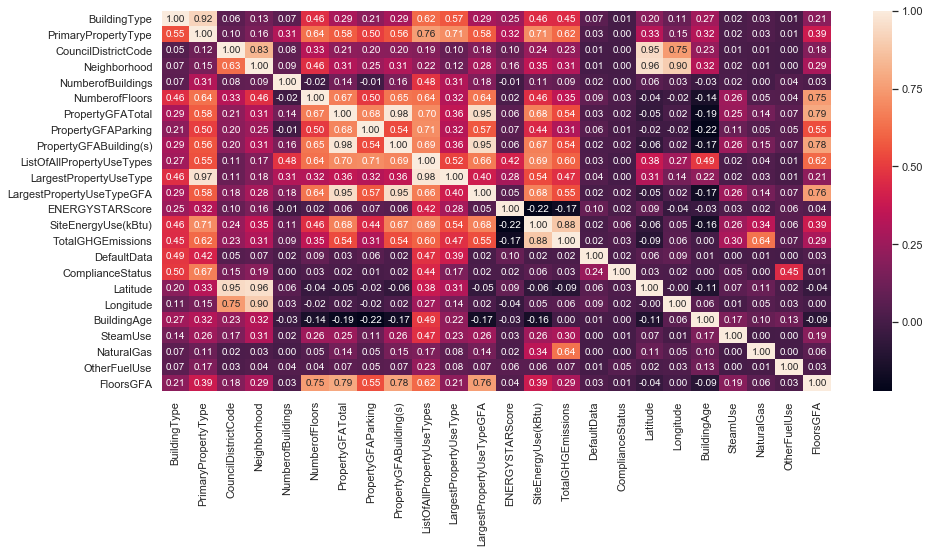

In [43]:
categorical_matrix(data)

Nous constatons qu'un sous-ensemble des variables sont très fortement corrélées entre elles (**multicolinéarité**).

Nous pouvons aussi constater que la variable **'ENERGYSTARScore'** présente un coefficient de corrélation linéaire très faible avec les variables à expliquer ('TotalGHGEmissions', 'SiteEnergyUse(kBtu)'). Cela laisse entendre que cette variable ne sera pas très importante pour notre modèle, mais nous le confirmerons avec une analyse de l'importance des variables (*features importance*) a posteriori.

## **Sauvegarde** (méthode *feather*)

In [44]:
# feather does not support serializing a non-default index
data = data.reset_index()

# Deleting index
data = data.drop(columns=["index"])

# Save the file (binary)
data.to_feather("p4_data_w_colinear_w_outliers.ft")

## Suppression des données fortement **corrélées**
Nous allons supprimer les variables fortement corrélées entre elles (sauf une), telles qu'apparaissant d'après la matrice des interactions. Éliminer les variables colinéaires permet d'augmenter la vitesse d'apprentissage, l'interprétabilité, la stabilité et de réduire le fléau de la dimension. Cela peut néanmoins diminuer un peu la précision du modèle.

In [45]:
# 'BuildingType' and 'PrimaryPropertyType' are strongly correlated
# We keep 'PrimaryPropertyType' (more correlated to the targets)
data = data.drop(columns=['BuildingType'])

# 'CouncilDistrictCode','Neighborhood', 'Latitude' and 'Longitude' are strongly correlated
# We keep 'Neighborhood' (more correlated to the targets)
data = data.drop(columns=['CouncilDistrictCode', 'Latitude', 'Longitude'])

# 'PropertyGFATotal', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA' are strongly correlated
# We keep 'LargestPropertyUseTypeGFA' (more correlated to the targets)
data = data.drop(columns=['PropertyGFATotal', 'PropertyGFABuilding(s)'])

# 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'PrimaryPropertyType' are strongly correlated
# We keep 'PrimaryPropertyType' (more correlated to the targets)
data = data.drop(columns=['ListOfAllPropertyUseTypes', 'LargestPropertyUseType'])

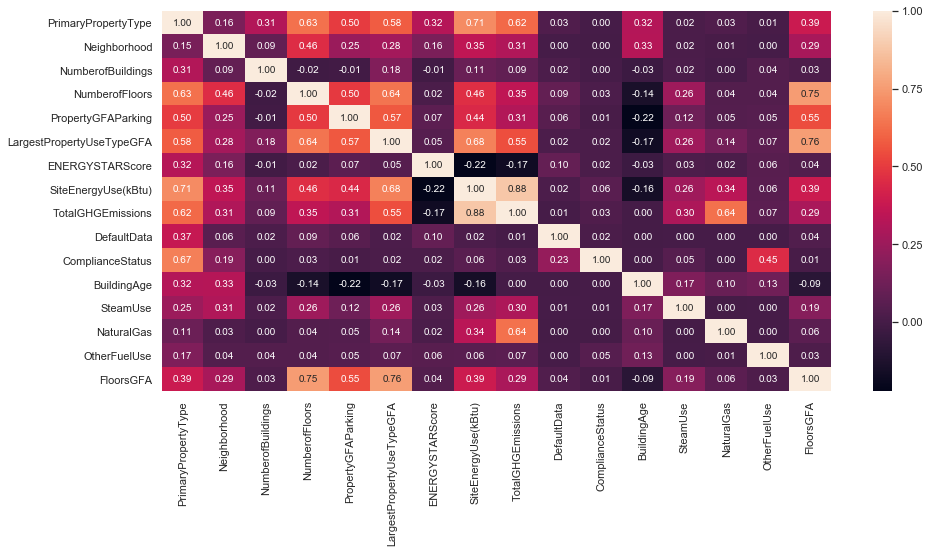

In [46]:
categorical_matrix(data)

In [47]:
data.dtypes

PrimaryPropertyType          category
Neighborhood                 category
NumberofBuildings             float64
NumberofFloors                float64
PropertyGFAParking            float64
LargestPropertyUseTypeGFA     float64
ENERGYSTARScore               float64
SiteEnergyUse(kBtu)           float64
TotalGHGEmissions             float64
DefaultData                      bool
ComplianceStatus             category
BuildingAge                     int64
SteamUse                         bool
NaturalGas                       bool
OtherFuelUse                     bool
FloorsGFA                     float64
dtype: object

In [48]:
data.head()

,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFAParking,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,DefaultData,ComplianceStatus,BuildingAge,SteamUse,NaturalGas,OtherFuelUse,FloorsGFA
0,Low-Rise Multifamily,DOWNTOWN,1.0,4.0,0.0,38172.0,75.0,14.898447,4.727919,False,Compliant,119,True,True,False,193532.0
1,Low-Rise Multifamily,DELRIDGE,1.0,4.0,0.0,52134.0,85.0,14.008238,2.246015,True,Compliant,12,False,False,False,208536.0
2,Retail Store,DOWNTOWN,1.0,4.0,0.0,NaN,91.0,16.107917,4.248638,False,Compliant,30,False,False,False,444308.0
3,Small- and Mid-Sized Office,DOWNTOWN,1.0,6.0,25920.0,98370.0,45.0,15.691288,3.876189,False,Compliant,113,False,True,False,434700.0
4,Large Office,LAKE UNION,1.0,4.0,37854.0,138672.0,59.0,16.634519,4.769328,False,Compliant,72,False,False,False,623736.0


## **Sauvegarde** (méthode *feather*)

In [49]:
# feather does not support serializing a non-default index
data = data.reset_index()

# Deleting index
data = data.drop(columns=["index"])

# Save the file (binary)
data.to_feather("p4_data_w_outliers.ft")

# Suppression des **valeurs hors-normes**

In [50]:
def IQR_outliers_mask(dataframe, feature='TARGET'):
    """This function return a mask of outliers.
    Outliers are those with value less than (Q1 + 1.5*IQR) or bigger than (Q3 + 1.5*IQR)"""
    
    Q1 = dataframe[feature].quantile(q=0.25, interpolation='linear')   # first quartile
    Q3 = dataframe[feature].quantile(q=0.75, interpolation='linear')   # third quartile
    IQR = Q3 - Q1                                                      # inter-quartile range
    
    # definition of mask of outliers
    mask = (dataframe[feature] < Q1 - 1.5*IQR) | (dataframe[feature] > Q3 + 1.5*IQR)
    
    # application of mask
    outliers = dataframe[mask]
    
    # Displays number of outliers
    print("Number of detected outliers:", len(mask[mask]))
    
    # return the mask of outliers
    return mask

In [51]:
mask1 = IQR_outliers_mask(data, feature='TotalGHGEmissions')
mask2 = IQR_outliers_mask(data, feature='SiteEnergyUse(kBtu)')
mask = mask1 | mask2

# Deleting outliers
data = data[~mask]

print("Données restantes :", len(data))

Number of detected outliers: 16
Number of detected outliers: 72
Données restantes : 3356


## **Sauvegarde** (méthode *feather*)

In [ ]:
# feather does not support serializing a non-default index
data = data.reset_index()

# Deleting index
data = data.drop(columns=["index"])

# Save the file (binary)
data.to_feather("p4_data.ft")

# **Visualisation des données** (par t-SNE)

In [53]:
data = data.drop(columns=['SiteEnergyUse(kBtu)'])

In [54]:
def define_preprocessor(X):
    """Pre-processing function to use before t-SNE and PCA:
        - impute missing values
        - target encode categorical features
        - standardization of all features
    """

    # Load libraries
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from category_encoders.target_encoder import TargetEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.impute import SimpleImputer
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer
    
    # Preprocessing pipeline for categorical features
    categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # simple imputation 
            ('target_encoder', TargetEncoder()), # target encoding
            ('scaler', StandardScaler()), # standardization after target encoding
            ])
    
    # Preprocessing pipeline for numeric features
    numeric_transformer = Pipeline(steps=[
            ('imputer', IterativeImputer(max_iter=10)), # iterative imputation
            ('scaler', StandardScaler()), # standardization
             ])

    # Preprocessing column-wise using pipelines for numeric and categorical features
    preprocessor = ColumnTransformer(transformers=[
            ('cat', categorical_transformer, list(X.select_dtypes(include=['category', 'bool']).columns)),
            ('num', numeric_transformer, list(X.select_dtypes(include='number').columns)),
            ])
    
    return preprocessor

### Pré-traitement

In [55]:
def preprocessing_tSNE(dataframe, target_name='TARGET'):
    
    X = dataframe.copy()

    # Dropping rows with missing target values
    X = X.dropna(subset=[target_name])

    # Setting the target variable (used for coloration only)
    y = X[target_name]

    # Removing the target from features
    X = X.drop(columns=[target_name])

    # Instanciate preprocessor
    preprocessor = define_preprocessor(X)

    # Apply the preprocessor to the data
    X_std = preprocessor.fit_transform(X, y)
    
    return (X_std, y)

In [56]:
def tSNE(dataframe, target_name='TARGET'):
    """Compute the tSNE. Displays the embedding on 2 dimensions."""
    
    # Preprocessing for t-SNE
    #------------------------
    (X_std, y) = preprocessing_tSNE(dataframe, target_name)

    # Applying the t-SNE
    #-------------------
    # Import libraries
    from sklearn import manifold

    # Instanciation of t-SNE
    tsne = manifold.TSNE(n_components=2,
                         perplexity=30,
                         n_iter=300,
                         init='pca', # initialisation by a PCA
                         random_state=0
                        )

    # Applying the t-SNE
    X_projected = tsne.fit_transform(X_std) # t-SNE do not have ".transform" method

    # Plotting the t-SNE embedding
    #-----------------------------
    plt.figure(figsize=(12,7))

    # Definitions of axis boundaries
    plt.xlim(X_projected[:,0].min()*1.1, X_projected[:,0].max()*1.1)
    plt.ylim(X_projected[:,1].min()*1.1, X_projected[:,1].max()*1.1)

    # Definition of axis'labels
    plt.title("t-SNE\n", fontsize=20)
    plt.xlabel("t-SNE feature 1")
    plt.ylabel("t-SNE feature 2")

    # Plotting the scatter plot
    sc = plt.scatter(X_projected[:,0], # x-coordinate
                 X_projected[:,1], # y-coordinate
                 # y.iloc[i,0], # labels
                 c=y, # base for coloration of points
                 cmap=plt.cm.get_cmap('RdYlGn_r'), # colormap
        )
    
    # Set-up and displays the colorbar
    cbar = plt.colorbar(sc)
    cbar.ax.get_yaxis().set_ticks([])
    cbar.ax.get_yaxis().labelpad = 15
    cbar.set_label(target_name, rotation=90)

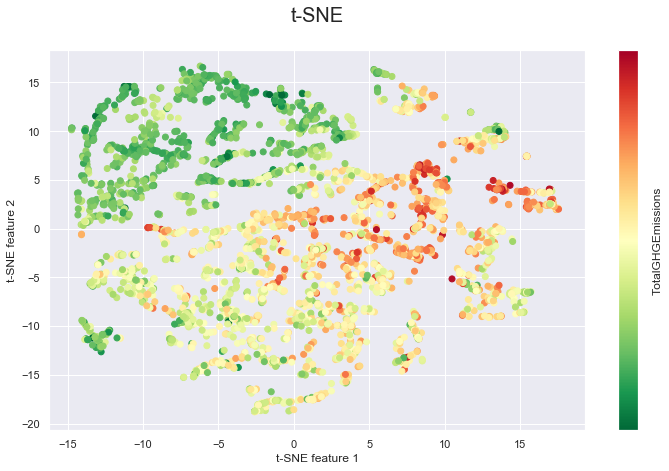

In [57]:
tSNE(data, target_name='TotalGHGEmissions')

# **Visualisation des données** (par ACP)

### Calcul des composantes principales

In [58]:
# Preprocessing for ACP
dataframe = data
target_name = 'TotalGHGEmissions'
(X_std, y) = preprocessing_tSNE(dataframe, target_name)

# Calcul des composantes principales
from sklearn import decomposition
n_components=2
pca = decomposition.PCA(n_components=n_components)
pca.fit(X_std)

print("Percentage of explained variance by component:", pca.explained_variance_ratio_)
print("Total percentage of explained variance:", pca.explained_variance_ratio_.sum()) #  somme cumulée

Percentage of explained variance by component: [0.22587368 0.11049814]
Total percentage of explained variance: 0.33637182821019634


### Cercle des corrélations

In [59]:
def display_circles(dataframe, target_name='TARGET'):
            import random

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,7))
            
            # Defining labels (without target)
            labels=list(dataframe.columns)
            labels.remove(target_name)
            
            # Preprocessing for the PCA
            (X_std, y) = preprocessing_tSNE(dataframe, target_name)
            
            # Applying the PCA
            pca = decomposition.PCA(n_components=2)
            X_projected = pca.fit_transform(X_std)
            pcs = pca.components_

            # détermination des limites du graphique
            xmin, xmax, ymin, ymax = -1.05, 1.05, -1.05, 1.05
            
            # generator of colors:
            import pylab
            cm = pylab.get_cmap('gist_rainbow')
            NUM_COLORS = len(labels)
            cycle = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

            # affichage des flèches
            for i, (x, y) in enumerate(pcs[[0,1]].T):
                plt.quiver(
                    np.zeros(pcs.shape[1]),
                    np.zeros(pcs.shape[1]),
                    pcs[0,:][i], pcs[1,:][i],
                    angles='xy', scale_units='xy',
                    scale=1,
                    width=0.005,
                    color=cycle[i],
                    label=labels[i],
                )
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)

            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F1 ({}%)'.format(round(100*pca.explained_variance_ratio_[0],1)))
            plt.ylabel('F2 ({}%)'.format(round(100*pca.explained_variance_ratio_[1],1)))

            plt.title("Cercle des corrélations (F1 et F2)", fontsize=15)
            
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels)
            ax.legend(loc="upper left", bbox_to_anchor=(1,1))

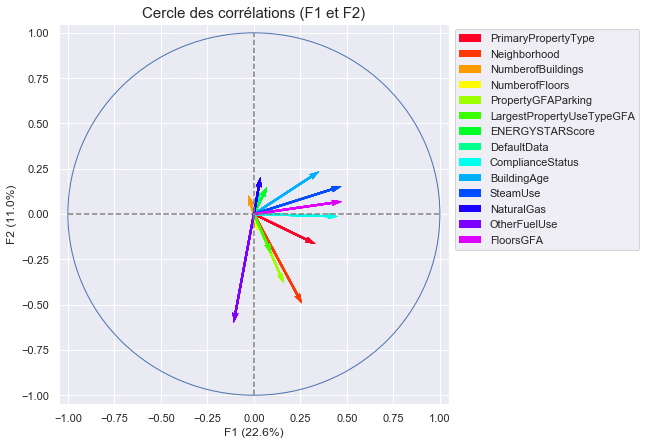

In [60]:
display_circles(data, target_name='TotalGHGEmissions')

### Projection des individus dans le premier plan factoriel

In [61]:
def display_factorial_planes(dataframe, target_name):
    """This function displays the scree plot of proper values
    for PCA decomposition.

    Future improvements
    -------------------
    * coloration of points depending on values of target, including categorical target
    * simplification of code
    * finish documentation and translate comments
    """

    # initialisation de la figure       
    fig = plt.figure(figsize=(15,8))
            
    # Preprocessing for the PCA
    (X_std, y) = preprocessing_tSNE(dataframe, target_name)
            
    # Applying the PCA
    pca = decomposition.PCA(n_components=2)
    X_projected = pca.fit_transform(X_std)
    pcs = pca.components_
    
    # affichage des points
    plt.scatter(X_projected[:, 0], X_projected[:, 1], c=y, cmap=plt.cm.get_cmap('RdYlGn_r'),)
    
    # Set-up and displays the colorbar
    cbar = plt.colorbar()
    cbar.ax.get_yaxis().set_ticks([])
    cbar.ax.get_yaxis().labelpad = 15
    cbar.set_label(target_name, rotation=90)

    # affichage des labels des points
    # for i,(x,y) in enumerate(X_projected[:,[0,1]]):
        # plt.text(x, y, labels[i], fontsize='14', ha='center',va='center',) 

    # détermination des limites du graphiquè
    boundary_right = np.max(np.abs(X_projected[:,0])) * 1.1
    boundary_left = np.min(X_projected[:,0]) * 1.3
    boundary_up = np.max(X_projected[:,1]) * 1.1
    boundary_down = np.min(X_projected[:,1]) * 1.1
    plt.xlim([boundary_left, boundary_right])
    plt.ylim([boundary_down, boundary_up])

    # affichage des lignes horizontales et verticales
    plt.plot([-100, 100], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-100, 100], color='grey', ls='--')

    # nom des axes, avec le pourcentage d'inertie expliquée
    plt.xlabel('F1 ({}%)'.format(round(100*pca.explained_variance_ratio_[0],1)))
    plt.ylabel('F2 ({}%)'.format(round(100*pca.explained_variance_ratio_[1],1)))

    plt.title("Projection des individus (sur F1 et F2)", fontsize=15)
    plt.show(block=False)

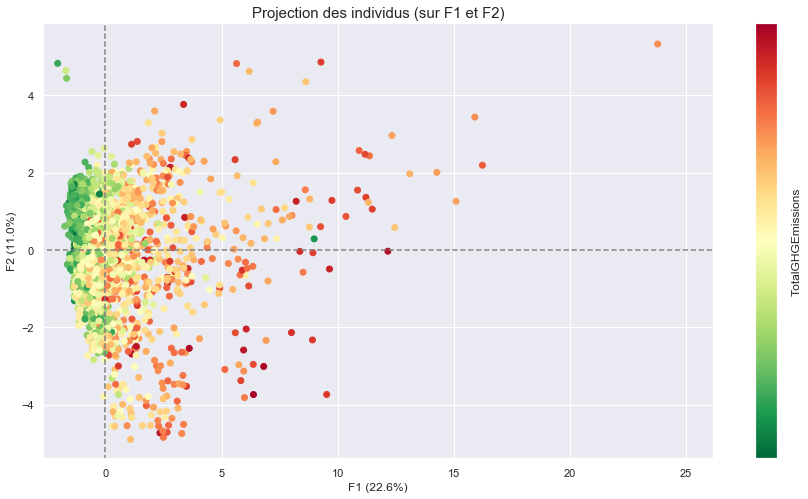

In [62]:
display_factorial_planes(data, target_name='TotalGHGEmissions')

### Eboulis des valeurs propres

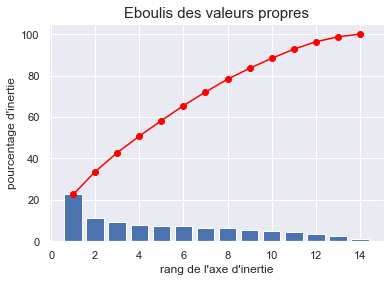

In [63]:
def display_scree_plot(X_std):
    """This function displays the scree plot of proper values
    for PCA decomposition.
    
    Parameters
    --------
    X_std (pandas.DataFrame or np.ndarray):
        The standardised data (features).
   
    Future improvements
    -------------------
    * english translation
    * unit thicks
    """
    pca = decomposition.PCA()
    pca.fit(X_std)
    scree = pca.explained_variance_ratio_*100
    
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres", fontsize=15)
    plt.show(block=False)

display_scree_plot(X_std)

### Récupération des axes d'inerties jusqu'à 90% de variance

In [64]:
def PCA_features_reduction(X_std, var_threshold=0.9):
    """Return the principal components from PCA, until variance threshold."""

    from sklearn import decomposition
    
    # Processing the PCA
    pca = decomposition.PCA()
    pca.fit(X_std)
    
    # Getting the explained variance ratio for each principal component
    scree = pca.explained_variance_ratio_

    # Getting the number of principal components to reach variance thresholds
    mask = scree.cumsum() > var_threshold
    nb_selected_features = len(scree[~mask]) + 1
    print("Number of selected features:", nb_selected_features)
    
    # Compute and displays the actual ratio of explained variance
    explained_variance_sum = scree.cumsum()[nb_selected_features-1]
    print("Cumulative explained variance:  {:.2f}%".format(explained_variance_sum*100))
    
    # Getting the projection of the data on the first components
    X_projected = pca.transform(X_std)[:,:nb_selected_features]
    
    return X_projected

In [65]:
X_projected = PCA_features_reduction(X_std, var_threshold=0.9)
X_projected.shape

Number of selected features: 11
Cumulative explained variance:  92.73%


(3356, 11)

Le seuil de 90% de variance expliquée est atteint avec les 11 premières composantes principales. Le jeu de données, avant l'ACP, comportait 14 variables explicatives + 2 variables à expliquer.

### Sauvegarde des résultats de l'ACP pour modélisation

In [66]:
# Converting target as array of shape (_,1)
y = np.asarray(y)
y = y.reshape((-1, 1))

# Concatenating back features (from PCA) and target
data_PCA = np.concatenate((X_projected, y), axis=1)

# Save the data from PCA into a .csv file
np.savetxt("p4_dataPCA.csv", data_PCA, delimiter=",")

In [67]:
# Save the kernel
import dill

dill.dump_session('kernels/p4_explor_kernel.db')